In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
stockfiles=['TCL中环','大全能源','恩捷股份','福斯特','赣锋锂业','华友钴业','晶澳科技','晶盛机电','龙源电力','隆基绿能','宁德时代',
             '三峡能源','天赐材料','天合光能','天齐锂业','通威股份','阳光电源','亿纬锂能','中国广核','中国核电']

In [257]:
stockfiles=['中国广核']

In [258]:
#获取股票数
stock_data = pd.read_excel('中国广核cleaned.xlsx')
company='中国广核'

In [259]:
from datetime import datetime

# 定义字符串
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y-%m-%d')
# 计算日收益率
stock_data['daily_return'] = (stock_data['ClosePrice'] - stock_data['OpenPrice']) / stock_data['OpenPrice']
stock_data = stock_data.dropna()
stock_data = stock_data.reset_index()
stock_data = stock_data.drop('index', axis=1)
stock_data=stock_data.drop('Unnamed: 0', axis=1)
stock_data=stock_data.drop('ClosePrice_returns', axis=1)
stock_data

,StockCode,StockName,Date,OpenPrice,HighestPrice,LowestPrice,ClosePrice,Turnover,TradingVolume,daily_return
0,003816.SZ,中国广核,2019-08-27,3.95,3.95,3.95,3.95,13.82,3.499300e+06,0.000000
1,003816.SZ,中国广核,2019-08-28,4.35,4.35,4.35,4.35,30.17,6.936100e+06,0.000000
2,003816.SZ,中国广核,2019-08-29,4.79,4.79,4.79,4.79,58.99,1.231600e+07,0.000000
3,003816.SZ,中国广核,2019-08-30,5.22,5.25,4.80,5.18,6270.40,1.263080e+09,-0.007663
4,003816.SZ,中国广核,2019-09-02,4.91,4.96,4.71,4.85,2949.14,6.073343e+08,-0.012220
...,...,...,...,...,...,...,...,...,...,...
881,003816.SZ,中国广核,2023-04-17,3.27,3.32,3.26,3.30,373.17,1.230955e+08,0.009174
882,003816.SZ,中国广核,2023-04-18,3.30,3.30,3.26,3.28,233.38,7.729400e+07,-0.006061
883,003816.SZ,中国广核,2023-04-19,3.28,3.36,3.26,3.27,368.25,1.210423e+08,-0.003049
884,003816.SZ,中国广核,2023-04-20,3.28,3.30,3.23,3.29,324.58,1.078165e+08,0.003049


In [260]:
# 定义Dα和Dβ的阈值
alpha = 0.01
beta = -0.01

In [261]:
# 初始化事件状态列和生存时间列
stock_data['is_alpha'] = 0
stock_data['is_beta'] = 0
stock_data['T_alpha'] = 0
stock_data['T_beta'] = 0
stock_data['last_alpha_index'] = 0
stock_data['last_beta_index'] = 0
# 初始化上一次出现Dα和Dβ的index
last_alpha_index = 0
last_beta_index = 0

In [262]:
# 遍历每一天的数据，更新事件状态和生存时间
# 更新Dα状态和生存时间
# 遍历每一天的数据，更新事件状态和生存时间
# 更新Dα状态和生存时间
for i in range(len(stock_data)):
    if stock_data.loc[i, 'daily_return'] > alpha:
      stock_data.loc[i, 'is_alpha'] = 1
      stock_data.loc[i, 'last_alpha_index'] = last_alpha_index
      last_alpha_index = i
    else:
      stock_data.loc[i, 'is_alpha'] = 0
      stock_data.loc[i, 'last_alpha_index'] = last_alpha_index
for i in range(len(stock_data)):
  if i == 0:
    stock_data.loc[i, 'T_alpha'] = 1
  else:
    if stock_data.loc[i, 'last_alpha_index'] == 0 and stock_data.loc[0, 'is_alpha'] == 0:
      stock_data.loc[i, 'T_alpha'] = i - stock_data.loc[i, 'last_alpha_index'] + 1
    else:
      stock_data.loc[i, 'T_alpha'] = i - stock_data.loc[i, 'last_alpha_index']
# 更新Dβ状态和生存时间
# 更新Dβ状态和生存时间
for i in range(len(stock_data)):
    if stock_data.loc[i, 'daily_return'] < beta:
      stock_data.loc[i, 'is_beta'] = 1
      stock_data.loc[i, 'last_beta_index'] = last_beta_index
      last_beta_index = i
    else:
      stock_data.loc[i, 'is_beta'] = 0
      stock_data.loc[i, 'last_beta_index'] = last_beta_index
for i in range(len(stock_data)):
  if i == 0:
    stock_data.loc[i, 'T_beta'] = 1
  else:
    if stock_data.loc[i, 'last_beta_index'] == 0 and stock_data.loc[0, 'is_beta'] == 0:
      stock_data.loc[i, 'T_beta'] = i - stock_data.loc[i, 'last_beta_index'] + 1
    else:
      stock_data.loc[i, 'T_beta'] = i - stock_data.loc[i, 'last_beta_index']

In [263]:
import ta
# Define time range for covariates
T = 30  # number of days

# Calculate the cumulative returns from the latest event to current time
stock_data['cumulative_returns'] = (pd.Series(np.cumprod(1 + stock_data["daily_return"][::-1]), index=stock_data.index[::-1])).values[::-1]
# Calculate AcROC
stock_data['AcROC'] = stock_data['cumulative_returns']

# Calculate AvROC
stock_data['AvROC'] = stock_data['cumulative_returns'].rolling(window=len(stock_data), min_periods=1).mean()

# Calculate AcT
stock_data['AcT'] = np.cumsum(stock_data['Turnover'][::-1]).fillna(0)[::-1]

# Calculate AvT
stock_data['AvT'] = stock_data['Turnover'].rolling(window=T).mean().fillna(0)

# Calculate K%
rolling_high = stock_data['ClosePrice'].rolling(window=T).max()
rolling_low = stock_data['ClosePrice'].rolling(window=T).min()
stock_data['K%'] = (stock_data['ClosePrice'] - rolling_low) / (rolling_high - rolling_low) * 100

# Calculate D%
stock_data['D%'] = stock_data['K%'].rolling(window=T).mean().fillna(0)

# Calculate J%
stock_data['J%'] = 3 * stock_data['K%'] - 2 * stock_data['D%']


# Calculate RSI
def calc_rsi(x):
    if len(x[x >= 0]) == 0:
        return 0
    if len(x[x < 0]) == 0:
        return 100
    avg_gain = x[x >= 0].mean()
    avg_loss = -x[x < 0].mean()
    rs = avg_gain / avg_loss
    return 100 - 100 / (1 + rs)
stock_data['RSI'] = stock_data['ClosePrice'].pct_change().rolling(window=T).apply(calc_rsi, raw=True).fillna(0)

# Calculate PSY
stock_data['PSY'] = stock_data["daily_return"].apply(lambda x: 1 if x > 0 else 0).rolling(window=len(stock_data), min_periods=1).mean()


# Print the resulting data frame
print(stock_data)

     StockCode StockName       Date  OpenPrice  HighestPrice  LowestPrice  \
0    003816.SZ      中国广核 2019-08-27       3.95          3.95         3.95   
1    003816.SZ      中国广核 2019-08-28       4.35          4.35         4.35   
2    003816.SZ      中国广核 2019-08-29       4.79          4.79         4.79   
3    003816.SZ      中国广核 2019-08-30       5.22          5.25         4.80   
4    003816.SZ      中国广核 2019-09-02       4.91          4.96         4.71   
..         ...       ...        ...        ...           ...          ...   
881  003816.SZ      中国广核 2023-04-17       3.27          3.32         3.26   
882  003816.SZ      中国广核 2023-04-18       3.30          3.30         3.26   
883  003816.SZ      中国广核 2023-04-19       3.28          3.36         3.26   
884  003816.SZ      中国广核 2023-04-20       3.28          3.30         3.23   
885  003816.SZ      中国广核 2023-04-21       3.28          3.34         3.26   

     ClosePrice  Turnover  TradingVolume  daily_return  ...  \
0          3

In [264]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   StockCode           886 non-null    object        
 1   StockName           886 non-null    object        
 2   Date                886 non-null    datetime64[ns]
 3   OpenPrice           886 non-null    float64       
 4   HighestPrice        886 non-null    float64       
 5   LowestPrice         886 non-null    float64       
 6   ClosePrice          886 non-null    float64       
 7   Turnover            886 non-null    float64       
 8   TradingVolume       886 non-null    float64       
 9   daily_return        886 non-null    float64       
 10  is_alpha            886 non-null    int64         
 11  is_beta             886 non-null    int64         
 12  T_alpha             886 non-null    int64         
 13  T_beta              886 non-null    int64         

In [265]:
stock_dataa = stock_data.drop('daily_return',axis = 1)
stock_dataa = stock_dataa.drop(['StockCode','StockName','OpenPrice','HighestPrice','LowestPrice','ClosePrice','Turnover','TradingVolume'], axis = 1)

In [266]:
stock_datab=stock_dataa 

# Rise Model using Aplha

In [267]:
stock_dataa = stock_dataa.drop(['last_alpha_index','last_beta_index','is_beta','T_beta','cumulative_returns'], axis = 1)

In [268]:
stock_dataa = stock_dataa.dropna()
stock_dataa = stock_dataa.reset_index()
stock_dataa = stock_dataa.drop('index', axis=1)
# 设置日期列为索引
stock_dataa = stock_dataa.set_index('Date')
stock_dataa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 857 entries, 2019-10-15 to 2023-04-21
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   is_alpha  857 non-null    int64  
 1   T_alpha   857 non-null    int64  
 2   AcROC     857 non-null    float64
 3   AvROC     857 non-null    float64
 4   AcT       857 non-null    float64
 5   AvT       857 non-null    float64
 6   K%        857 non-null    float64
 7   D%        857 non-null    float64
 8   J%        857 non-null    float64
 9   RSI       857 non-null    float64
 10  PSY       857 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 80.3 KB


In [269]:
Xa = stock_dataa
ya = stock_dataa[['is_alpha', 'T_alpha']]# replace 'target_variable' with the name of the variable you're trying to predict
# 将历史数据作为训练集
# 将2023年2月份的数据作为测试集
Xa_train = Xa.loc[:'2022-12-30']
Xa_test  =Xa.loc['2023-01-01':'2023-03-31']
Xa_train  # t alpha 本质上由 is alpha获得
Xa_train  # t alpha 本质上由 is alpha获得
Xa_train1=Xa_train.drop('is_alpha',axis = 1)
Xa_train1=Xa_train1.drop('T_alpha',axis = 1)
ya_train = ya.loc[:'2022-12-30']
ya_test=ya.loc['2023-01-01':'2023-03-31']
from lifelines import CoxPHFitter
Xa_test = Xa_test.drop('is_alpha',axis = 1)
Xa_test =Xa_test.drop('T_alpha',axis = 1)

In [270]:
# 创建Cox回归模型
cph = CoxPHFitter(penalizer=0.1)

# 使用训练集对模型进行拟合
cph.fit(Xa_train, duration_col='T_alpha', event_col='is_alpha', show_progress=True)

Iteration 1: norm_delta = 0.62314, step_size = 0.9500, log_lik = -854.85015, newton_decrement = 56.53766, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.06077, step_size = 0.9500, log_lik = -802.19704, newton_decrement = 0.42089, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00274, step_size = 0.9500, log_lik = -801.77902, newton_decrement = 0.00081, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -801.77821, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 784 total observations, 638 right-censored observations>

In [271]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
AcROC,-2.933335e-02,0.971093,0.278262,-0.574716,0.516049,0.562865,1.675396,0.0,-0.105416,0.916045,0.126509
AvROC,4.397086e-01,1.552255,0.659919,-0.853709,1.733126,0.425833,5.658313,0.0,0.666307,0.505215,0.985031
AcT,-4.766047e-07,1.000000,0.000002,-0.000004,0.000003,0.999996,1.000003,0.0,-0.302065,0.762602,0.390997
AvT,1.564200e-03,1.001565,0.000458,0.000666,0.002463,1.000666,1.002466,0.0,3.412171,0.000644,10.599586
K%,1.016075e-02,1.010213,0.002734,0.004803,0.015519,1.004814,1.015640,0.0,3.716863,0.000202,12.275415
D%,1.541406e-03,1.001543,0.003700,-0.005710,0.008793,0.994306,1.008832,0.0,0.416596,0.676974,0.562828
J%,3.793376e-03,1.003801,0.000944,0.001943,0.005644,1.001944,1.005660,0.0,4.017118,0.000059,14.051027
RSI,2.455483e-02,1.024859,0.008177,0.008528,0.040581,1.008565,1.041416,0.0,3.002934,0.002674,8.546835
PSY,5.493007e-01,1.732041,1.948008,-3.268724,4.367325,0.038055,78.832499,0.0,0.281981,0.777958,0.362235


In [272]:
# 计算每个自变量的 Wald 检验 p 值
p_values = cph.summary['p']

# 设置显著性水平为 0.05，得到阈值
alpha = 0.4
threshold = alpha / len(p_values)

# 筛选显著的自变量
significant_vars = ['T_alpha','is_alpha']
for var, p in p_values.iteritems():
    if p < threshold:
        significant_vars.append(var)
significant_vars
# 重新拟合模型，保留显著的自变量
cph.fit(Xa_train[significant_vars], duration_col='T_alpha', event_col='is_alpha', show_progress=True)

Iteration 1: norm_delta = 0.61950, step_size = 0.9500, log_lik = -854.85015, newton_decrement = 55.85610, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.05362, step_size = 0.9500, log_lik = -802.54675, newton_decrement = 0.37173, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00249, step_size = 0.9500, log_lik = -802.17759, newton_decrement = 0.00073, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -802.17686, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 784 total observations, 638 right-censored observations>

In [273]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
AvT,0.001560,1.001561,0.000432,0.000713,0.002406,1.000713,1.002409,0.0,3.611408,0.000305,11.681085
K%,0.010631,1.010687,0.002614,0.005507,0.015755,1.005522,1.015879,0.0,4.066335,0.000048,14.353890
J%,0.003687,1.003694,0.000922,0.001880,0.005494,1.001882,1.005509,0.0,3.998801,0.000064,13.939156
RSI,0.025328,1.025652,0.007909,0.009827,0.040830,1.009875,1.041675,0.0,3.202449,0.001363,9.519374


In [274]:
from lifelines.utils import concordance_index


# 计算C-index
c_index = concordance_index(ya_test['T_alpha'], -cph.predict_partial_hazard(Xa_test), ya_test['is_alpha'])

# 输出C-index
print("C-index:", c_index)

C-index: 0.9783783783783784


In [275]:
survival_func=cph.predict_survival_function(Xa_test,conditional_after=ya_test['T_alpha'])
partial_hazards = cph.predict_partial_hazard(Xa_test.iloc[[0]]) #.iloc[[0]]
probabilities = 1 - survival_func.apply(lambda x: np.exp(-x * partial_hazards.squeeze())) # Use squeeze() to match the dimensions
probabilities = probabilities.head(10)
probabilities

,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-09,2023-01-10,2023-01-11,2023-01-12,2023-01-13,2023-01-16,...,2023-03-20,2023-03-21,2023-03-22,2023-03-23,2023-03-24,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31
1.0,0.546798,0.664692,0.664692,0.664692,0.664692,0.589372,0.664692,0.664692,0.664692,0.664692,...,0.632902,0.638455,0.637068,0.621748,0.636178,0.647064,0.649609,0.654695,0.640002,0.655186
2.0,0.546798,0.664692,0.664692,0.664692,0.575752,0.589372,0.664692,0.664692,0.664692,0.664692,...,0.603659,0.618707,0.583819,0.575968,0.611393,0.630824,0.638252,0.635363,0.629687,0.636431
3.0,0.546798,0.664692,0.664692,0.562743,0.575752,0.589372,0.664692,0.664692,0.664692,0.162429,...,0.581786,0.580756,0.561830,0.536844,0.588680,0.618618,0.616332,0.627293,0.609391,0.636431
4.0,0.546798,0.664692,0.563306,0.562743,0.575752,0.589372,0.664692,0.664692,0.187317,0.162429,...,0.540108,0.565057,0.519271,0.501713,0.571710,0.595119,0.607201,0.611417,0.609391,0.604894
5.0,0.546798,0.549820,0.563306,0.562743,0.575752,0.589372,0.664692,0.253322,0.187317,0.162429,...,0.523013,0.534501,0.519271,0.475986,0.539328,0.585355,0.589272,0.611417,0.575445,0.591981
6.0,0.406662,0.549820,0.563306,0.562743,0.575752,0.589372,0.226151,0.253322,0.187317,0.162429,...,0.490002,0.534501,0.450893,0.428309,0.526002,0.566228,0.589272,0.584821,0.561615,0.576552
7.0,0.406662,0.549820,0.563306,0.562743,0.575752,0.185514,0.226151,0.253322,0.187317,0.162429,...,0.490002,0.484560,0.424257,0.409272,0.500146,0.566228,0.559361,0.573955,0.545144,0.548909
8.0,0.406662,0.549820,0.563306,0.562743,0.140430,0.185514,0.226151,0.253322,0.187317,0.162429,...,0.436836,0.464692,0.393574,0.373376,0.500146,0.534461,0.547192,0.560981,0.515792,0.548909
9.0,0.406662,0.549820,0.563306,0.106814,0.140430,0.185514,0.226151,0.253322,0.187317,0.162429,...,0.415974,0.441427,0.341900,0.373376,0.458013,0.521590,0.532704,0.537746,0.515792,0.534679
10.0,0.406662,0.549820,0.108101,0.106814,0.140430,0.185514,0.226151,0.253322,0.187317,0.162429,...,0.391764,0.401115,0.341900,0.318010,0.441259,0.506309,0.506882,0.537746,0.500764,0.499694


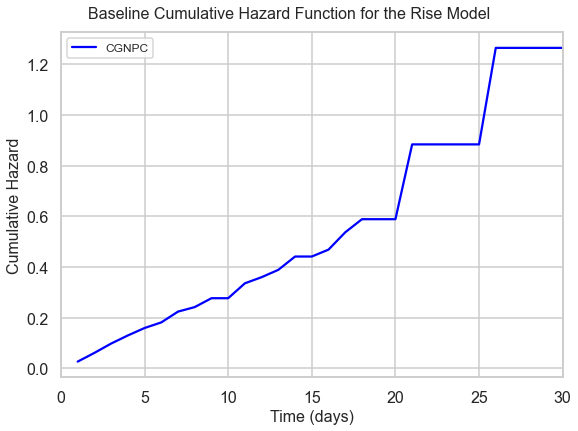

In [279]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
#from lifelines import CoxPHFitter
# Calculate baseline cumulative hazard function
baseline_cumulative_hazard = cph.baseline_cumulative_hazard_
# Set the style of the plot
sns.set_style('whitegrid')

# Plot the baseline cumulative hazard function up to 20 days
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 30)
ax.set_xlabel('Time (days)', fontsize=16)
ax.set_ylabel('Cumulative Hazard', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(baseline_cumulative_hazard.iloc[:30], label='CGNPC',color='blue')
ax.legend(fontsize=12)

# Add title and adjust spacing
plt.suptitle('Baseline Cumulative Hazard Function for the Rise Model', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Show the plot
plt.show()

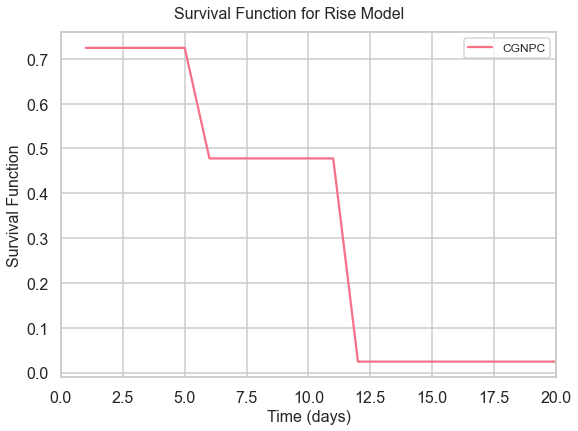

In [281]:
# Import necessary packages
import matplotlib.pyplot as plt
import seaborn as sns

individual_survival = cph.predict_survival_function(Xa_test.iloc[[0]], conditional_after=ya_test['T_alpha'][0])

# Plot the baseline cumulative hazard function up to 20 days
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 20)
ax.set_xlabel('Time (days)', fontsize=16)
ax.set_ylabel('Survival Function', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(individual_survival, label='CGNPC')
ax.legend(fontsize=12)

# Add title and adjust spacing
plt.suptitle('Survival Function for Rise Model', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Show plot
plt.show()

# Drop Model using Beta

In [282]:
stock_datab = stock_datab.drop(['last_alpha_index','last_beta_index','is_alpha','T_alpha','cumulative_returns'], axis = 1)
stock_datab = stock_datab.dropna()
stock_datab = stock_datab.reset_index()
stock_datab = stock_datab.drop('index', axis=1)

# 设置日期列为索引
stock_datab = stock_datab.set_index('Date')

In [283]:
Xb = stock_datab
yb = stock_datab[['is_beta', 'T_beta']]
# 将历史数据作为训练集
# 将2023年2月份的数据作为测试集
Xb_train = Xb.loc[:'2022-12-30']
Xb_test  =Xb.loc['2023-01-02':'2023-03-31']

In [284]:
# t alpha 本质上由 is alpha获得
Xb_train1=Xb_train.drop('is_beta',axis = 1)
Xb_train1=Xb_train1.drop('T_beta',axis = 1)
yb_train = yb.loc[:'2022-12-30']
yb_test=yb.loc['2023-01-02':'2023-03-31']


In [285]:
from lifelines import CoxPHFitter
Xb_test = Xb_test.drop('is_beta',axis = 1)
Xb_test =Xb_test.drop('T_beta',axis = 1)

In [286]:
# 创建Cox回归模型
cph = CoxPHFitter(penalizer=0.2)

# 使用训练集对模型进行拟合
cph.fit(Xb_train, duration_col='T_beta', event_col='is_beta', show_progress=True)

Iteration 1: norm_delta = 0.44975, step_size = 0.9500, log_lik = -720.41907, newton_decrement = 26.00940, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.04666, step_size = 0.9500, log_lik = -696.95068, newton_decrement = 0.35184, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00361, step_size = 0.9500, log_lik = -696.59448, newton_decrement = 0.00202, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00001, step_size = 1.0000, log_lik = -696.59246, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 784 total observations, 659 right-censored observations>

In [287]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
AcROC,-1.049623e-01,0.900359,0.205501,-0.507737,0.297813,0.601856,1.346910,0.0,-0.510762,0.609518,0.714260
AvROC,-2.466172e-01,0.781440,0.488797,-1.204643,0.711408,0.299799,2.036857,0.0,-0.504539,0.613883,0.703965
AcT,5.272557e-08,1.000000,0.000001,-0.000002,0.000002,0.999998,1.000002,0.0,0.045555,0.963665,0.053396
AvT,1.747052e-03,1.001749,0.000385,0.000992,0.002503,1.000992,1.002506,0.0,4.532395,0.000006,17.387609
K%,-2.782999e-03,0.997221,0.002093,-0.006886,0.001320,0.993137,1.001321,0.0,-1.329361,0.183729,2.444349
D%,4.898718e-03,1.004911,0.002951,-0.000886,0.010683,0.999115,1.010741,0.0,1.659805,0.096954,3.366561
J%,-1.673780e-03,0.998328,0.000735,-0.003114,-0.000234,0.996891,0.999766,0.0,-2.277818,0.022737,5.458787
RSI,6.126700e-03,1.006146,0.006704,-0.007013,0.019266,0.993012,1.019453,0.0,0.913906,0.360766,1.470864
PSY,-4.302464e+00,0.013535,1.532014,-7.305157,-1.299772,0.000672,0.272594,0.0,-2.808371,0.004979,7.649848


In [288]:
# 计算每个自变量的 Wald 检验 p 值
p_values = cph.summary['p']

# 设置显著性水平为 0.05，得到阈值
alpha = 0.4
threshold = alpha / len(p_values)

# 筛选显著的自变量
significant_vars = ['T_beta','is_beta']
for var, p in p_values.iteritems():
    if p < threshold:
        significant_vars.append(var)
significant_vars
# 重新拟合模型，保留显著的自变量
cph.fit(Xb_train[significant_vars], duration_col='T_beta', event_col='is_beta', show_progress=True)

Iteration 1: norm_delta = 0.43655, step_size = 0.9500, log_lik = -720.41907, newton_decrement = 22.82695, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.04552, step_size = 0.9500, log_lik = -699.94700, newton_decrement = 0.34208, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00375, step_size = 0.9500, log_lik = -699.59967, newton_decrement = 0.00222, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00001, step_size = 1.0000, log_lik = -699.59745, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 784 total observations, 659 right-censored observations>

In [289]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
AvT,0.001915,1.001917,0.000377,0.001175,0.002654,1.001176,1.002658,0.0,5.076191,3.850760e-07,21.308354
J%,-0.002027,0.997975,0.000675,-0.003349,-0.000705,0.996656,0.999295,0.0,-3.005023,2.655610e-03,8.556741
PSY,-3.493858,0.030383,1.400672,-6.239123,-0.748592,0.001952,0.473032,0.0,-2.494416,1.261646e-02,6.308550


In [290]:
from lifelines.utils import concordance_index


# 计算C-index
c_index = concordance_index(yb_test['T_beta'], -cph.predict_partial_hazard(Xb_test), yb_test['is_beta'])

# 输出C-index
print("C-index:", c_index)

C-index: 0.7485029940119761


In [291]:
survival_func=cph.predict_survival_function(Xb_test,conditional_after=yb_test['T_beta'])
partial_hazards = cph.predict_partial_hazard(Xb_test.iloc[[0]]) 
probabilities = 1 - survival_func.apply(lambda x: np.exp(-x * partial_hazards.squeeze())) # Use squeeze() to match the dimensions
probabilities = probabilities.head(10)
probabilities

,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-09,2023-01-10,2023-01-11,2023-01-12,2023-01-13,2023-01-16,...,2023-03-20,2023-03-21,2023-03-22,2023-03-23,2023-03-24,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31
1.0,0.575141,0.575803,0.574237,0.574274,0.578818,0.572607,0.580306,0.573665,0.583656,0.579342,...,0.555676,0.584896,0.584896,0.584896,0.584896,0.572355,0.571830,0.577173,0.571016,0.579343
2.0,0.566493,0.565125,0.568246,0.568303,0.567068,0.567946,0.569303,0.572326,0.577865,0.566119,...,0.555676,0.584896,0.584896,0.584896,0.444870,0.565310,0.564492,0.562258,0.565754,0.566040
3.0,0.556342,0.565125,0.556667,0.556765,0.562611,0.556778,0.567991,0.566068,0.564080,0.558101,...,0.555676,0.584896,0.584896,0.460805,0.172042,0.551708,0.550328,0.556608,0.553154,0.564454
4.0,0.556342,0.565125,0.552278,0.552390,0.551935,0.555447,0.561862,0.551192,0.555723,0.548625,...,0.555676,0.584896,0.462727,0.203228,0.172042,0.546557,0.544965,0.543092,0.551653,0.557052
5.0,0.556342,0.553545,0.541768,0.541916,0.550662,0.549231,0.547292,0.542186,0.545851,0.540236,...,0.555676,0.455947,0.207261,0.203228,0.172042,0.534235,0.532142,0.541482,0.544647,0.539483
6.0,0.545336,0.532028,0.540515,0.540667,0.544720,0.534470,0.538473,0.531560,0.537115,0.530404,...,0.436760,0.193298,0.207261,0.203228,0.172042,0.532768,0.530615,0.533975,0.528027,0.528870
7.0,0.524895,0.523070,0.534669,0.534841,0.530610,0.525545,0.528069,0.522170,0.526880,0.530404,...,0.193890,0.193298,0.207261,0.203228,0.172042,0.525925,0.523497,0.516194,0.517993,0.516374
8.0,0.516386,0.512188,0.520793,0.521012,0.522077,0.515025,0.518876,0.511183,0.526880,0.530404,...,0.193890,0.193298,0.207261,0.203228,0.172042,0.509712,0.506640,0.505476,0.506183,0.505357
9.0,0.506050,0.485529,0.512408,0.512653,0.512019,0.505737,0.508120,0.511183,0.526880,0.519760,...,0.193890,0.193298,0.207261,0.203228,0.172042,0.499936,0.496483,0.492881,0.495773,0.492502
10.0,0.480726,0.468744,0.502527,0.502805,0.503138,0.494881,0.508120,0.511183,0.515806,0.500034,...,0.193890,0.193298,0.207261,0.203228,0.172042,0.488441,0.484547,0.481796,0.483627,0.492502


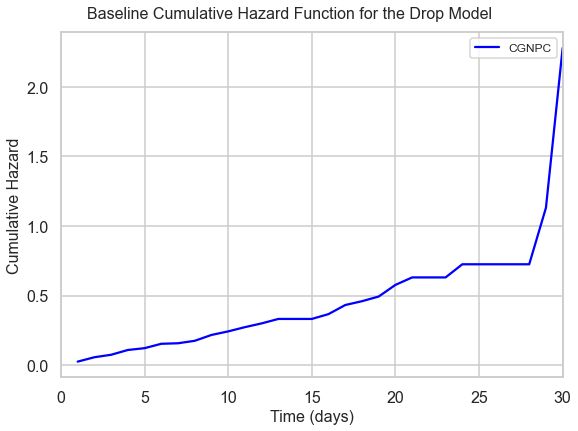

In [292]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
#from lifelines import CoxPHFitter
# Calculate baseline cumulative hazard function
baseline_cumulative_hazard = cph.baseline_cumulative_hazard_
# Set the style of the plot
sns.set_style('whitegrid')

# Plot the baseline cumulative hazard function up to 20 days
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 30)
ax.set_xlabel('Time (days)', fontsize=16)
ax.set_ylabel('Cumulative Hazard', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(baseline_cumulative_hazard.iloc[:30], label='CGNPC',color='blue')
ax.legend(fontsize=12)

# Add title and adjust spacing
plt.suptitle('Baseline Cumulative Hazard Function for the Drop Model', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Show the plot
plt.show()

In [293]:
Xb_test.iloc[[0]]

,AcROC,AvROC,AcT,AvT,K%,D%,J%,RSI,PSY
Date,,,,,,,,,
2023-01-03,1.071445,1.526032,19344.98,209.105,36.842105,51.442045,7.642225,54.120155,0.432432


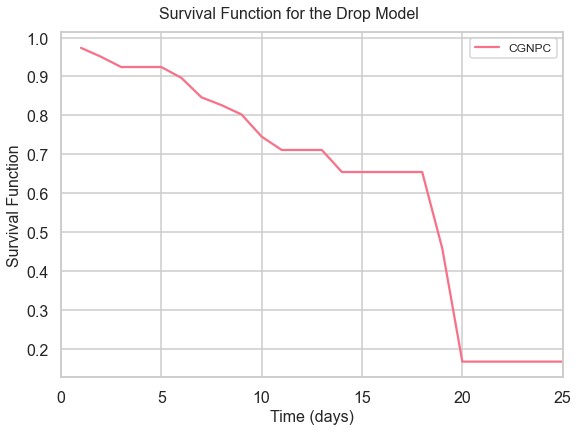

In [294]:
# Import necessary packages
import matplotlib.pyplot as plt
import seaborn as sns

individual_survival = cph.predict_survival_function(Xb_test.iloc[[0]], conditional_after=yb_test['T_beta'][0])

# Plot the baseline cumulative hazard function up to 20 days
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 25)
ax.set_xlabel('Time (days)', fontsize=16)
ax.set_ylabel('Survival Function', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(individual_survival, label='CGNPC')
ax.legend(fontsize=12)

# Add title and adjust spacing
plt.suptitle('Survival Function for the Drop Model', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Show plot
plt.show()
